In [2]:
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from closed_circuit import *
import pyswarms as ps
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline

In [6]:
file_path_1 = 'lv_p.csv'
file_path_2 = 'la_p.csv'
file_path_3 = 'rv_p.csv'
file_path_4 = 'ra_p.csv'
file_path_5 = 'ao_p.csv'
file_path_6 = 'pa_p.csv'
lvp = pd.read_csv(file_path_1, sep=',', na_values=['NA', '?'], names=['t', 'y'])
lap = pd.read_csv(file_path_2, sep=',', na_values=['NA', '?'], names=['t', 'y'])
rvp = pd.read_csv(file_path_3, sep=',', na_values=['NA', '?'], names=['t', 'y'])
rap = pd.read_csv(file_path_4, sep=',', na_values=['NA', '?'], names=['t', 'y'])
aop = pd.read_csv(file_path_5, sep=',', na_values=['NA', '?'], names=['t', 'y'])
pap = pd.read_csv(file_path_6, sep=',', na_values=['NA', '?'], names=['t', 'y'])
xx = np.arange(0,0.8,0.01)
bspl = make_interp_spline(lvp['t'], lvp['y'], k=3)
lvp_st = bspl(xx)

bspl = make_interp_spline(lap['t'], lap['y'], k=3)
lap_st = bspl(xx)

bspl = make_interp_spline(rvp['t'], rvp['y'], k=3)
rvp_st = bspl(xx)

bspl = make_interp_spline(rap['t'], rap['y'], k=3)
rap_st = bspl(xx)

bspl = make_interp_spline(aop['t'], aop['y'], k=3)
aop_st = bspl(xx)

bspl = make_interp_spline(pap['t'], pap['y'], k=3)
pap_st = bspl(xx)

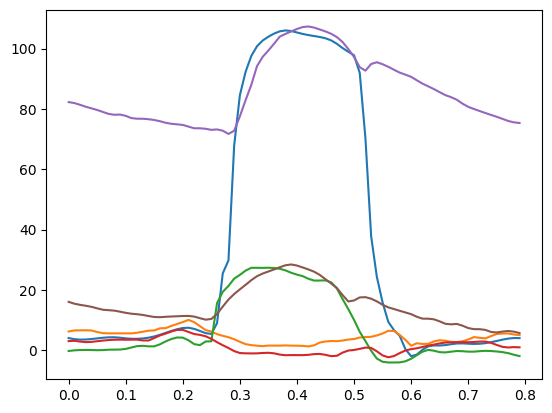

In [7]:
plt.plot(xx,lvp_st)
plt.plot(xx,lap_st)
plt.plot(xx,rvp_st)
plt.plot(xx,rap_st)
plt.plot(xx,aop_st)
plt.plot(xx,pap_st)
plt.show()

In [96]:
t_end=10
t = [0,t_end]
t_span=np.arange(0,t_end,0.01)
aeff_av_values = []
et_lv = []
p_lv_values=[]
time=[]

In [97]:
def dydt(t, y, 
    tau1_lv, tau2_lv, m1_lv, m2_lv, Emax_lv, Emin_lv,
    tau1_rv, tau2_rv, m1_rv, m2_rv, Emax_rv, Emin_rv,
    tau1_la, tau2_la, m1_la, m2_la, Emax_la, Emin_la,
    tau1_ra, tau2_ra, m1_ra, m2_ra, Emax_ra, Emin_ra,
    C_s, R_s, Za_s,
    C_p, R_p, Za_p,
    l_av, A_av,
    l_pv, A_pv):
    lv = heart(tau1 = tau1_lv, tau2 = tau2_lv, # tau1,2 (s)
         m1 = m1_lv, m2 = m2_lv, # m1,2
         Emax = Emax_lv,Emin = Emin_lv, # Emax,min (mmHg/mL)
        V0 = 10,T = T)# V0 (mL), T (s)

    la = heart(tau1 = tau1_la, tau2 = tau2_la, #tau1,2
             m1 = m1_la,m2 = m2_la, # m1,2
             Emax = Emax_la, Emin = Emin_la, #Emax,min(mmHg/mL)
             V0 = 3,T = T) # V0 (mL), T (s)

    av = ValveinP(density = 1.06, eff_length = l_av,Aann = A_av, # density, eff_length(cm), Aann
                Kvo = 0.12,Kvc = 0.15, # Kvo,Kvc
                p_oc = 0) #poc

    mv = ValveinP(density = 1.06,eff_length =1.9,Aann = 5, # density, eff_length(cm), Aann
                Kvo = 0.3,Kvc = 0.4, # Kvo,Kvc
                p_oc = 0) #poc

    #cap_s=PressureSystem(0.0008, 90, 700)#C,Za,R
    cap_s=PressureSystem(C_s, Za_s, R_s)

    rv=heart(tau1 = tau1_rv,tau2 = tau2_rv,  # tau1, 2
             m1 = m1_rv,m2 = m2_rv, # m1,2
             Emax = Emax_rv,Emin = Emin_rv, #Emax, min
             V0 = 10,T = T) # Ks, V0 ,T

    ra=heart(tau1 = tau1_ra,tau2 = tau2_ra, # tau1, 2
             m1 = m1_ra,m2 = m2_ra, # m1,2
             Emax = Emax_ra,Emin = Emin_ra, # Emax,min
             V0 = 3, T = T) # Ks, V0, T

    tv=ValveinP(1.06,2,6, # density, eff_length, Aann(cm2)
                0.3,0.4, # Kvo,Kvc
                0) #poc (mmHg)

    pv=ValveinP(1.06,l_pv,A_pv, # density, eff_length, Aann(cm2)
                0.2,0.2, # Kvo,Kvc
                0) #poc

    #cap_p=PressureSystem(0.0017, 10, 71.25)#C,Za,R
    cap_p=PressureSystem(C_p, Za_p, R_p)
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t,0.85*T)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t,0.85*T)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp_original(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp_original(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy
def obj_fun1(params):
    tau1_lv = params[0]
    tau2_lv = params[1]
    m1_lv = params[2]
    m2_lv = params[3]
    Emax_lv = params[4]
    Emin_lv = params[5]
    
    tau1_rv = params[6]
    tau2_rv = params[7]
    m1_rv = params[8]
    m2_rv = params[9]
    Emax_rv = params[10]
    Emin_rv = params[11]
    
    tau1_la = params[12]
    tau2_la = params[13]
    m1_la = params[14]
    m2_la = params[15]
    Emax_la = params[16]
    Emin_la = params[17]
    
    tau1_ra = params[18]
    tau2_ra = params[19]
    m1_ra = params[20]
    m2_ra = params[21]
    Emax_ra = params[22]
    Emin_ra = params[23]
    
    C_s = params[24]
    R_s = params[25]
    Za_s = params[26]
    
    C_p = params[27]
    R_p = params[28]
    Za_p = params[29]
    
    l_av = params[30]
    A_av = params[31]
    l_pv = params[32]
    A_pv = params[33]
    if Emax_lv < Emin_lv or Emax_rv < Emin_rv or Emax_la < Emin_la or Emax_ra < Emin_ra:
        return 200
    params_tuple = (
    tau1_lv, tau2_lv, m1_lv, m2_lv, Emax_lv, Emin_lv,
    tau1_rv, tau2_rv, m1_rv, m2_rv, Emax_rv, Emin_rv,
    tau1_la, tau2_la, m1_la, m2_la, Emax_la, Emin_la,
    tau1_ra, tau2_ra, m1_ra, m2_ra, Emax_ra, Emin_ra,
    C_s, R_s, Za_s,
    C_p, R_p, Za_p,
    l_av, A_av,
    l_pv, A_pv)

    sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, args = params_tuple, method='LSODA')
    
    lv = heart(tau1 = tau1_lv, tau2 = tau2_lv, # tau1,2 (s)
         m1 = m1_lv, m2 = m2_lv, # m1,2
         Emax = Emax_lv,Emin = Emin_lv, # Emax,min (mmHg/mL)
        V0 = 10,T = T)# V0 (mL), T (s)

    la = heart(tau1 = tau1_la, tau2 = tau2_la, #tau1,2
             m1 = m1_la,m2 = m2_la, # m1,2
             Emax = Emax_la, Emin = Emin_la, #Emax,min(mmHg/mL)
             V0 = 3,T = T) # V0 (mL), T (s)
    rv=heart(tau1 = tau1_rv,tau2 = tau2_rv,  # tau1, 2
             m1 = m1_rv,m2 = m2_rv, # m1,2
             Emax = Emax_rv,Emin = Emin_rv, #Emax, min
             V0 = 10,T = T) # Ks, V0 ,T
    ra=heart(tau1 = tau1_ra,tau2 = tau2_ra, # tau1, 2
             m1 = m1_ra,m2 = m2_ra, # m1,2
             Emax = Emax_ra,Emin = Emin_ra, # Emax,min
             V0 = 3, T = T) # Ks, V0, T
    cap_s=PressureSystem(C_s, Za_s, R_s)
    cap_p=PressureSystem(C_p, Za_p, R_p)
    v_lv = sol.y[0]
    v_la = sol.y[1]
    q_av = sol.y[2]
    pa = sol.y[6]
    v_rv = sol.y[7]
    v_ra = sol.y[8]
    q_pv = sol.y[10]
    pb = sol.y[13]
    p_lv = []
    p_la = []
    p_ao = []
    p_rv = []
    p_pa = []
    p_ra = []
    for i,j in zip(sol.t,range(len(sol.t))):
        p_lv.append(lv.p(v_lv[j], i))
        p_la.append(la.p(v_la[j], i, 0.85*T))
        p_ao.append(cap_s.pi(q_av[j],pa[j]))
        p_rv.append(rv.p(v_rv[j],i))
        p_pa.append(cap_p.pi(q_pv[j],pb[j]))
        p_ra.append(ra.p(v_ra[j],i, 0.85*T))
    
    p_lv = list(map(lambda x: x / 1333, p_lv))
    p_la = list(map(lambda x: x / 1333, p_la))
    p_ao = list(map(lambda x: x / 1333, p_ao))
    p_rv = list(map(lambda x: x / 1333, p_rv))
    p_pa = list(map(lambda x: x / 1333, p_pa))
    p_ra = list(map(lambda x: x / 1333, p_ra))
    max_volume_rv = max(v_rv[880:980])
    min_volume_rv = min(v_rv[880:980])
    sv_rv = max_volume_rv - min_volume_rv
    max_volume_lv = max(v_lv[880:980])
    min_volume_lv = min(v_lv[880:980])
    sv_lv = (max_volume_lv - min_volume_lv)
    rvef = sv_rv / max_volume_rv
    lvef = sv_lv / max_volume_lv
    
    #standard
    sv_lv_s = 70
    lvef_s = 0.59
    rvef_s = 0.61
    err_lvsv = [(sv_lv - sv_lv_s)/70]
    err_lvef = [(lvef - lvef_s)]
    err_rvef = [(rvef - rvef_s)]
    err_lvp = []
    err_lap = []
    err_rvp = []
    err_rap = []
    err_aop = []
    err_pap = []
    for num in range(0,80):
        err_lvp.append((p_lv[855+num] - lvp_st[num])/100)
        err_lap.append((p_la[855+num] - lap_st[num])/100)
        err_rvp.append((p_rv[855+num] - rvp_st[num])/100)
        err_rap.append((p_ra[855+num] - rap_st[num])/100)
        err_aop.append((p_ao[855+num] - aop_st[num])/100)
        err_pap.append((p_pa[855+num] - pap_st[num])/100)
    err = np.concatenate((err_lvp, err_lap, err_rvp,err_rap, err_aop, err_pap, err_lvsv, err_rvef, err_lvef))
    return np.sum(err**2)
T = 0.8
y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333])

def objective_function(params):
    all_err = []
    for param in params:
        all_err.append(obj_fun1(param))
    return all_err
if __name__ == "__main__":
    lb = [0.1*T, 0.1*T, 0.5, 1, 0.01, 0.01, 0.1*T, 0.1*T, 0.5, 1, 0.01, 0.01, 0.01*T, 0.01*T, 0.5,1,0.01,0.01, 0.01*T, 0.01*T, 0.5,1,0.1,0.01,0.0005,200,10,0.0005,50,10,1,2,1,2]   # low boundary
    ub = [1*T, 1*T, 10,20,10,10, 1*T, 1*T, 10,20,5,2, 1*T, 1*T, 10,20,2,1, 1*T, 1*T, 10,20,2,1,0.002,7000,500,0.002,200,200,4,8,4,8]  # up boundary
    bounds = (lb, ub)
    
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.8}
    optimizer = ps.single.GlobalBestPSO(n_particles=500, dimensions=34, options=options, bounds = bounds, ftol= 1e-8)
    cost, pos = optimizer.optimize(objective_function, iters=2000, n_processes = 32)

2024-07-17 14:22:21,971 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.8}
pyswarms.single.global_best:   0%|                                                                                                                                                                                                                                    |1/2000, best_cost=30.8
2024-07-17 14:22:50,481 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 30.805111236212884, best pos: [5.75826543e-01 1.12428847e-01 1.03364862e+00 1.08038621e+01
 7.06883716e+00 2.65163031e-01 4.44341977e-01 4.19599437e-01
 5.36744115e+00 8.24353625e+00 3.66390509e+00 5.85888642e-02
 6.65113479e-01 2.76933479e-01 8.37530572e+00 2.61175141e+00
 1.22351881e+00 3.00295839e-01 7.83043490e-01 3.20858820e-01
 3.40800208e+00 1.13448437e+01 8.75428116e-01 3.23651208e-01
 9.88494043e-04 1.95688416e+03 3.53792694e+02 1.70944469e-03
 8.41273021e+01 7.00165245e+01 1.8

In [98]:
tau1_lv, tau2_lv, m1_lv, m2_lv, Emax_lv, Emin_lv = pos[0], pos[1], pos[2], pos[3], pos[4], pos[5]
tau1_rv, tau2_rv, m1_rv, m2_rv, Emax_rv, Emin_rv = pos[6], pos[7], pos[8], pos[9], pos[10], pos[11]
tau1_la, tau2_la, m1_la, m2_la, Emax_la, Emin_la = pos[12], pos[13], pos[14], pos[15], pos[16], pos[17]
tau1_ra, tau2_ra, m1_ra, m2_ra, Emax_ra, Emin_ra = pos[18], pos[19], pos[20], pos[21], pos[22], pos[23]
C_s, R_s, Za_s = pos[24], pos[25], pos[26]
C_p, R_p, Za_p = pos[27], pos[28], pos[29] 
l_av, A_av, l_pv, A_pv = pos[30], pos[31], pos[32], pos[33]

print(f"Optimal Parameters:")
print(f"tau1_lv = {tau1_lv}, tau2_lv = {tau2_lv}, m1_lv = {m1_lv}, m2_lv = {m2_lv}, Emax_lv = {Emax_lv}, Emin_lv = {Emin_lv}")
print(f"tau1_rv = {tau1_rv}, tau2_rv = {tau2_rv}, m1_rv = {m1_rv}, m2_rv = {m2_rv}, Emax_rv = {Emax_rv}, Emin_rv = {Emin_rv}")
print(f"tau1_la = {tau1_la}, tau2_la = {tau2_la}, m1_la = {m1_la}, m2_la = {m2_la}, Emax_la = {Emax_la}, Emin_la = {Emin_la}")
print(f"tau1_ra = {tau1_ra}, tau2_ra = {tau2_ra}, m1_ra = {m1_ra}, m2_ra = {m2_ra}, Emax_ra = {Emax_ra}, Emin_ra = {Emin_ra}")
print(f"C_s = {C_s}, R_s = {R_s}, Za_s = {Za_s}")
print(f"C_p = {C_p}, R_p = {R_p}, Za_p = {Za_p}")
print(f"l_av = {l_av}, A_av = {A_av}, l_pv = {l_pv}, A_pv = {A_pv}")
print(f"Optimal Value: {cost}")

lv = heart(tau1=tau1_lv, tau2=tau2_lv, m1=m1_lv, m2=m2_lv, Emax=Emax_lv, Emin=Emin_lv, V0=10, T=T)
la = heart(tau1=tau1_la, tau2=tau2_la, m1=m1_la, m2=m2_la, Emax=Emax_la, Emin=Emin_la, V0=3, T=T)
rv = heart(tau1=tau1_rv, tau2=tau2_rv, m1=m1_rv, m2=m2_rv, Emax=Emax_rv, Emin=Emin_rv, V0=10, T=T)
ra = heart(tau1=tau1_ra, tau2=tau2_ra, m1=m1_ra, m2=m2_ra, Emax=Emax_ra, Emin=Emin_ra, V0=3, T=T)

av = ValveinP(density=1.06, eff_length=l_av, Aann=A_av, Kvo=0.12, Kvc=0.15, p_oc=0)
mv = ValveinP(density=1.06, eff_length=1.9, Aann=5, Kvo=0.3, Kvc=0.4, p_oc=0)
tv = ValveinP(density=1.06, eff_length=2, Aann=6, Kvo=0.3, Kvc=0.4, p_oc=0)
pv = ValveinP(density=1.06, eff_length=l_pv, Aann=A_pv, Kvo=0.2, Kvc=0.2, p_oc=0)

cap_s = PressureSystem(C_s, Za_s, R_s)
cap_p = PressureSystem(C_p, Za_p, R_p)  

Optimal Parameters:
tau1_lv = 0.5758265430218432, tau2_lv = 0.11242884746821495, m1_lv = 1.0336486239829654, m2_lv = 10.803862146012136, Emax_lv = 7.068837160074639, Emin_lv = 0.265163031137978
tau1_rv = 0.4443419766411679, tau2_rv = 0.41959943663925797, m1_rv = 5.367441149539571, m2_rv = 8.24353624952197, Emax_rv = 3.66390509258064, Emin_rv = 0.058588864192357384
tau1_la = 0.6651134787223862, tau2_la = 0.27693347922398814, m1_la = 8.375305721368186, m2_la = 2.6117514107164883, Emax_la = 1.2235188116166658, Emin_la = 0.3002958385050581
tau1_ra = 0.7830434903163975, tau2_ra = 0.3208588201929786, m1_ra = 3.4080020843848957, m2_ra = 11.344843731168627, Emax_ra = 0.8754281157746795, Emin_ra = 0.32365120767961064
C_s = 0.0009884940431637939, R_s = 1956.8841563297535, Za_s = 353.7926943952391
C_p = 0.0017094446925679143, R_p = 84.12730210393391, Za_p = 70.01652446147519
l_av = 1.8637953263061973, A_av = 4.434703964300868, l_pv = 3.0104577205115017, A_pv = 2.1493875151232418
Optimal Value: 30

In [99]:
def dydt(t,y):
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t,0.85*T)
    p_lv = lv.p(v_lv,t)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t,0.85*T)
    p_rv = rv.p(v_rv,t)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp_original(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp_original(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy
y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5*1333, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5*1333]) # pb

#integration
sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')
v_lv = sol.y[0]
v_la = sol.y[1]
q_av = sol.y[2]
q_mv = sol.y[3]
xi_av = sol.y[4]
xi_mv = sol.y[5]
pa = sol.y[6]
v_rv = sol.y[7]
v_ra = sol.y[8]
q_tv = sol.y[9]
q_pv = sol.y[10]
xi_tv = sol.y[11]
xi_pv = sol.y[12]
pb = sol.y[13]
p_lv_values = []
for i,j in zip(sol.t,range(len(sol.t))):
    p_lv_values.append(lv.p(v_lv[j], i))
p_lv_values = list(map(lambda x: x / 1333, p_lv_values))
t = np.arange(8.55,9.35,0.01)

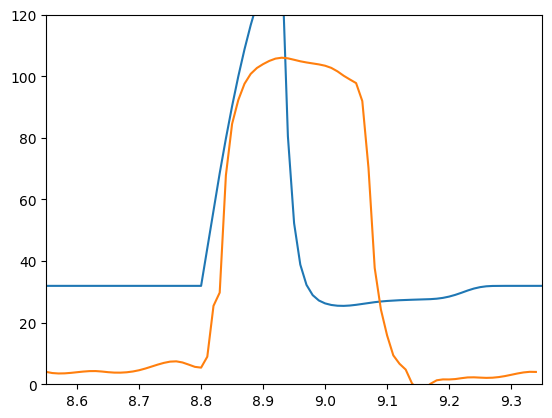

In [100]:
plt.plot(sol.t, p_lv_values)
plt.plot(t, lvp_st)
plt.xlim(8.55,9.35)
plt.ylim(0,120)
plt.show()

In [101]:
data_to_save = {
    'optimize_value': pos
}

np.savez_compressed('PSO_r.npz', **data_to_save)